# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Behavioral Cloning

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Prerequisite Code for Demonstration

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from datetime import timedelta
from time import time
from random import random
from PIL import Image
import os.path
import json
%matplotlib inline

# Helper function to plot images side-by-side with title
def plot_gallery(images, titles, h, w, n_row=3, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(2.0 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    llen = 21
    for i in range(min(n_row * n_col, len(images))):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        title_i = np.str(titles[i])
        if len(title_i) >= llen:
            title_i = titles[i][:llen] + '\n' + titles[i][llen:]
        plt.title(title_i, size=12)
        plt.xticks(())
        plt.yticks(())
        

# `train.pkl` is pre-pickled train set from data aquisition
train_file = 'train.pkl'
with open(train_file, mode='rb') as f:
    train = pickle.load(f)

X = train['images']
y = train['angles']

# Sub-samples of straight (low steering angles) points
y_smooth = np.where(abs(y) < 0.02)
X_smooth = X[y_smooth]

# Sub-samples of sharp turning (large steering angles) points
y_wavier = np.where(abs(y) > 0.40)
X_wavier = X[y_wavier]


## Step 0: Data Collection

#### Key attributes of this project are both data collection and model itself (next section).

+ To bless a performing model, I sampled ~6,000 very representitive data points
+ ~50% are recovery/correction data points (that move car back to track center)
+ ~50% are low steering angle (or straight) route, as smooth as possible w/ PS4
+ I'm considering to use sample_weight property in model.fit() to counter biases:
    - towards straight driving, as most length of track is straight or at low angle
    - method: add higher sample_weight for data point with larger |steer_angle|
    - This is pending TODO, I hope a good model be genrated with it only with no need of recovery record
+ End up train set using all 3 camera images w. an empirical L/R `angle calibration` to produce 3x data


#### Sample Images for driving on straight (large turning radius) or low steering angle routes:
+ Below 8 are nearly straight driving image samples post camera-angle calibration

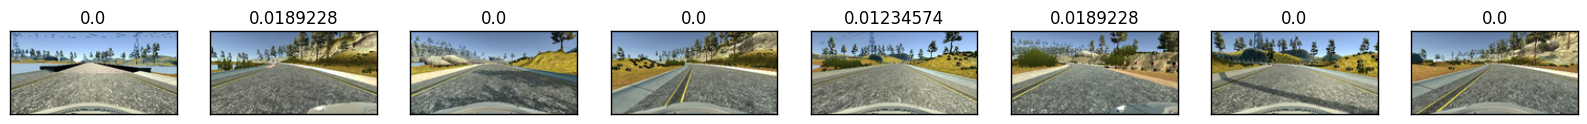

In [2]:
y_s8 = np.random.choice(y_smooth[0], size=8)
X_s8 = X[y_s8]

plot_gallery(X_s8, y[y_s8], 80, 160, 1, 8)

#### Sample Images for driving on wavier (small turning radius) or large steering angle routes:
+ Below 8 are sharp turning image samples (from L/C/R cameras) post camera-angle calibration
+ Center Images 1/2/4/5/7 clearly show recover angles recorded by simulator during correction!

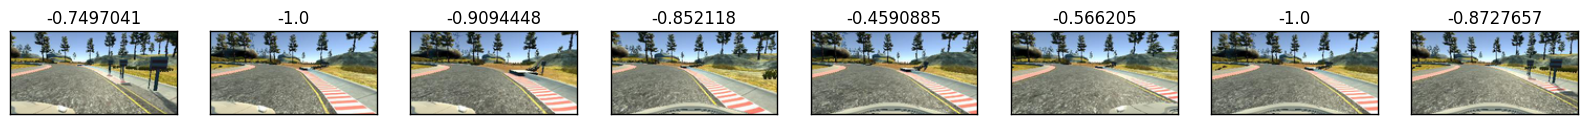

In [3]:
y_w8 = np.random.choice(y_wavier[0], size=8)
X_w8 = X[y_w8]

plot_gallery(X_w8, y[y_w8], 80, 160, 1, 8)

### By Visualizing corrective and non-corrective images above, we gain a good sense of the calibartion:
+ The more (facing) to the edge, the bigger absolute steering angle vehicle possess, which is correct in keeping vehicle on the track.
+ L/R calibation (linear: L=C+0.2, R=C-0.2) look reasonable (very close) compare to ground truth.

#### My Training Data has incorporated ~50% samples from recovery/correction records, which move CAR back on track from off side.

---

## Step 1: Data Pipeline - Input

### N.B. Computing environment (MacBookPro Core i7 / 4 Cores / 16GB RAM / CPU / TensorFlow / Keras)

#### Unused keras/python generator (Todo later considering some drawbacks, e.g. unable to use train_test_split()), because: 
+ ##### Sizable memory (16GB) available
+ ##### Down-sized image from (320x160) => (160x80) prior to pipeline, at pickling process
+ ##### Implemented data pickle from Pandas dataframe and Image input to numpy efficiently
+ ##### From schedule point of view, generator is as amortatized process of one time pickle with benefit of overcome memory constraint.

The pickled data is a dictionary with 2 key/value pairs:

- images   -> the images pixel values, in numpy array of shape (None, height, width, channels)
- angles   -> the output of vehicle steering angle in numpy array of 1-D 
- throttle -> the throttle applied to vehicle for speed control (none-implemented). Next todo: add this as 2nd regression output, and test vehicle performance on 2-D (steering, throttle) control in simulator!



In [ ]:
# Code snippet below just shows HOWTO pickle dataset (really code flow please refer to model.py)
# pickle images and sterring angles

train = {}

img = Image.open(df['center'][0])
img = img.resize((160, 80), Image.ANTIALIAS)
imga = np.asarray(img)
img_na = [imga]

angle = df['angle'][0]
ang_na = [angle]


linear = True
if linear:
    for i in range(1, df.shape[0]):
        # Center Image & Steering angles
        img_i = Image.open(df['center'][i])
        img_i = img_i.resize((160, 80), Image.ANTIALIAS)
        img_a = np.asarray(img_i)
        img_na = np.append(img_na, [img_a], axis=0)
        ang_i = df['angle'][i]
        ang_na = np.append(ang_na, [ang_i], axis=0)
        
        # Left Image & Steering adjusted (+0.2) bring it back
        img_i = Image.open(df['left'][i].strip())
        img_i = img_i.resize((160, 80), Image.ANTIALIAS)
        img_a = np.asarray(img_i)
        img_na = np.append(img_na, [img_a], axis=0)
        ang_i = df['angle'][i] + 0.2 # ver: x
        ang_na = np.append(ang_na, [ang_i], axis=0)

        # Initially I hoped to generate a good perfect w/o need of recover/correction record
        # So I spent lots of time to come up a `best` image-angle calibration scheme, failed:
        #  - whatever it does, it does not resolve the 1st sharp left after passing bridge!
        # Then I don't think regression is a good solution to predict this small turn radius,
        # Just like lower polynomial regression can hardly fit the points with high variance.
        # So there seem to be four options left as a solution, herein:
        #  1. Deep Learning (pure), with lots of recover/correction records
        #     - mathmatically increase the data densities at hard turns to fit
        #     - empirically spike up numeric values at hard turns to influence
        #  2. Deep Learning (pure), add higher sample_weight to samples of turns,
        #     without a need of recover/correction process. - This is TODO.
        #  3. Deep Learning (pure), model of two (steering, throttle), overcoming
        #     to feed constant throttle back to simulator in autonomous mode. TODO
        #  4. Harness advanced CV technique (as in upcoming Lesson 14 Advanced Lane Finding)
        #     to find predictable ground-truth (as it looks ahead), providing steering est.!

        # Right Image & Steering adjusted (-0.2)
        img_i = Image.open(df['right'][i].strip())
        img_i = img_i.resize((160, 80), Image.ANTIALIAS)
        img_a = np.asarray(img_i)
        img_na = np.append(img_na, [img_a], axis=0)
        ang_i = df['angle'][i] - 0.2 # ver: x
        ang_na = np.append(ang_na, [ang_i], axis=0)
else:
    # None linear smooth
    for i in range(1, df.shape[0]):
        dice = random()
        ang_i = df['angle'][i]
        if dice > 0.66:
            img_i = Image.open(df['center'][i])
            img_i = img_i.resize((160, 80), Image.ANTIALIAS)
            img_a = np.asarray(img_i)
            img_na = np.append(img_na, [img_a], axis=0)
            ang_na = np.append(ang_na, [ang_i], axis=0)
        elif dice > 0.33:
            # Left Image & Steering adjusted to bring vehicle on track
            img_i = Image.open(df['left'][i].strip())
            img_i = img_i.resize((160, 80), Image.ANTIALIAS)
            img_a = np.asarray(img_i)
            img_na = np.append(img_na, [img_a], axis=0)
            if ang_i < -0.1:
                # '-' left turn degree on left image 
                ang_i *= 0.8
            elif ang_i > 0.1:
                # '+' right turn degree on left image 
                ang_i *= 1.2
                #ang_i += 0.1
            else:
                # pick 0.1 as base calibrate (assume)
                # Ignored theta vehicle axis to road center line
                ang_i += 0.2
            ang_na = np.append(ang_na, [ang_i], axis=0)
        else:
            # Right Image & Steering adjusted to bring vehicle on track
            img_i = Image.open(df['right'][i].strip())
            img_i = img_i.resize((160, 80), Image.ANTIALIAS)
            img_a = np.asarray(img_i)
            img_na = np.append(img_na, [img_a], axis=0)
            if ang_i < -0.1:
                # '+' left turn degree on right image 
                ang_i *= 1.2
                #ang_i -= 0.1
            elif ang_i > 0.1:
                # '-' right turn degree on right image 
                ang_i *= 0.8
            else:
                # pick 0.1 as base calibrate
                ang_i -= 0.2
            ang_na = np.append(ang_na, [ang_i], axis=0)
    
train['images'] = img_na
train['angles'] = ang_na

with open('train.pkl', 'wb') as f:
    pickle.dump(train, f)



In [4]:
train['images'].shape

(17818, 80, 160, 3)

In [5]:
train['angles'].max()

0.44061250000000002

In [6]:
train['angles'].min()

-1.0

## Data Pipeline - Normalization

### N.B. Same normalization must be applied to test / predict data (as in drive.py) prior to model 

In [7]:
train['images'] = (train['images'] - 128.0)/128

#### Sample Images post Normalization:


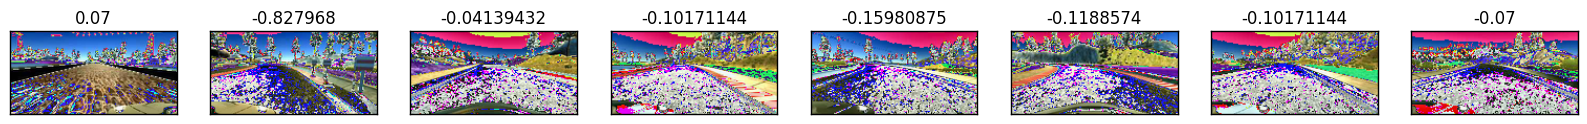

In [11]:
angles8 = np.random.choice(np.arange(len(train['angles'])), size=8)
images8 = train['images'][angles8]

plot_gallery(images8, train['angles'][angles8], 80, 160, 1, 8)


## MODEL - 5xCNN + 3xFC + 1Output (Total params: 182737)

#### To resolve this problem, I had come up with a similar DL neuron network
#### Refer to Nvidia Model (http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf)
#### But not identical, my model have 182,737 total params vs ~250K from Nvidia Model
#### I lowered model complexity in line with CPU enviornment

### Model Architecture (refer to model summary below) highlights:
- #### Consist of 5 ConvNet Layers
    + ##### First 3 use 5x5 kernel with 2x2 stride, with different depth
    + ##### Fourth uses 3x3 kernel with 2x2 stride, with depth of 64
    + ##### Fifth  uses 3x3 kernel with 1x1 stride, with depth of 64
    + ##### Relu nonelinear activation is used between CNN Layers
    + ##### No Dropout, Maxpooling, etc. is applied at CNN Layers    
- #### Consist of 3 Full Connected Hidden Layers
    + ##### ELU nonelinear activation is used between FC Layers
    + ##### Dropout(0.5) is tuned between FC Layers
- #### Consist of 1 neuron Output Layer (steering only) at this point
    + ##### No Dropout is applied between Hidden Layer to Output
    + ##### No nonelinear activation is applied to Output Layer.
- #### Model uses `'mean squared error'` as loss function in line with numerical regression
- #### Model uses `'Adam'` Optimizer with initial LR (learning rate) setting to: 0.00001 
- #### Model expect post preprocess and normalization Input tensor as input_shape=(80, 160, 3)

In [13]:
from keras.models import Sequential, Model
from keras.models import model_from_json
from keras.layers import Input, MaxPooling2D, Convolution2D, Dropout, Activation, Flatten, Dense
from keras.layers.advanced_activations import ELU
from keras.optimizers import Adam
from keras import initializations
from keras import backend as K

# have not found truncated_normal init. from Keras stocked initializations
# so come up one own to experient:
# equivalent to 0 mean tf.truncated_normal, except that it return np array

def trunc_norm(shape, stddev=0.1):
    norm = np.random.normal(scale=stddev, size=shape)
    trun = np.clip(norm, -2.0*stddev, 2.0*stddev)
    return trun

# Unable to load custom initializer from the saved model, passing custom_objects is not working
# so have to overload an existing initializations (we overload 'he_normal' as truncated_normal)
# https://github.com/fchollet/keras/issues/3867
# https://github.com/fchollet/keras/issues/1634

def he_normal(shape, name=None):
    value = trunc_norm(shape, stddev=0.001)
    return K.variable(value, name=name)


model = Sequential()

model.add(Convolution2D(nb_filter=24, nb_row=5, nb_col=5, init='he_normal', activation='relu', subsample=(2, 2), name='CNN1', input_shape=(80, 160, 3)))
model.add(Convolution2D(nb_filter=32, nb_row=5, nb_col=5, init='he_normal', activation='relu', subsample=(2, 2), name='CNN2'))
model.add(Convolution2D(nb_filter=48, nb_row=5, nb_col=5, init='he_normal', activation='relu', subsample=(2, 2), name='CNN3'))
model.add(Convolution2D(nb_filter=64, nb_row=3, nb_col=3, init='he_normal', activation='relu', subsample=(2, 2), name='CNN4'))
model.add(Convolution2D(nb_filter=64, nb_row=3, nb_col=3, init='he_normal', activation='relu', subsample=(1, 1), name='CNN5'))

model.add(Flatten(name='Flatten'))
model.add(Dense(128, init='he_normal', name='FC1'))
model.add(Dropout(0.5, name='DROP1'))
model.add(ELU())
model.add(Dense(64, init='he_normal', name='FC2'))
#model.add(Dropout(0.5, name='DROP2'))
model.add(ELU())
model.add(Dense(16, init='he_normal', name='FC3'))

# Linear activation fit well to output, steering angles are bewteen [-,+]
model.add(Dense(1, init='he_normal', name='Output'))
model.summary()

adam = Adam(lr=0.00001)
# N.B. accuracy is an improper metrics for this regression problem
#      may custom R^2 as model metrics later
model.compile(optimizer=adam, loss='mse')


Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
CNN1 (Convolution2D)             (None, 38, 78, 24)    1824        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
CNN2 (Convolution2D)             (None, 17, 37, 32)    19232       CNN1[0][0]                       
____________________________________________________________________________________________________
CNN3 (Convolution2D)             (None, 7, 17, 48)     38448       CNN2[0][0]                       
____________________________________________________________________________________________________
CNN4 (Convolution2D)             (None, 3, 8, 64)      27712       CNN3[0][0]                       
___________________________________________________________________________________________

### Data to feed Model
#### Train/Validation/Test Split

In [14]:
X = train['images']
y = train['angles']

# Randomize polarity
# Flip is a must !!!
for i in range(0, y.shape[0]):
    if np.random.choice([True, False]):
        X[i] = np.fliplr(X[i])
        y[i] = 0. - y[i]
        
# Use sklearn train_test_split() vs. Keras built-in validation split and shuffle in model.fit(), because:
#   Keras validation_split always choose last portion (pertentage) of pre-shuffle data as validation set,
#   So it is okay if data set is shuffled prior to the split, otherwise the validation set given by this
#   built-in keras parameter would be very bias towards the last period of training records!

# Choose Random ~10% as Validation set.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=101)

# Choose Udacity data as Test set in addition to on simulator testing :)

### Model Training / Validation
#### Save model at each epoch for testing on simulator and test data set

In [15]:
epoch_nums = 10
batch_size = 100

for i in range(epoch_nums):
    history = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=1, verbose=1, shuffle=True, validation_data=(X_val, y_val))
    # Save model at each epoch
    model_ith_arch = 'model' + str(i) + '.json'
    model_ith_parm = 'model' + str(i) + '.h5'

    model_architecture = model.to_json()
    with open(model_ith_arch, 'w') as f:
        json.dump(model_architecture, f, ensure_ascii=False)

    model.save_weights(model_ith_parm)

Train on 16036 samples, validate on 1782 samples
Epoch 1/1
16036/16036 [==============================] - 106s - loss: 0.0272 - val_loss: 0.0243
Train on 16036 samples, validate on 1782 samples
Epoch 1/1
16036/16036 [==============================] - 104s - loss: 0.0195 - val_loss: 0.0186
Train on 16036 samples, validate on 1782 samples
Epoch 1/1
16036/16036 [==============================] - 99s - loss: 0.0167 - val_loss: 0.0166
Train on 16036 samples, validate on 1782 samples
Epoch 1/1
16036/16036 [==============================] - 96s - loss: 0.0149 - val_loss: 0.0146
Train on 16036 samples, validate on 1782 samples
Epoch 1/1
16036/16036 [==============================] - 94s - loss: 0.0133 - val_loss: 0.0131
Train on 16036 samples, validate on 1782 samples
Epoch 1/1
16036/16036 [==============================] - 91s - loss: 0.0120 - val_loss: 0.0116
Train on 16036 samples, validate on 1782 samples
Epoch 1/1
16036/16036 [==============================] - 90s - loss: 0.0112 - val_los

### Model Testing on Udacity Data Set
#### Load and normalize testing data

In [16]:
# `udacity.pkl` was produced without take all 3 camera views

test_file = 'udacity.pkl'
with open(test_file, mode='rb') as f:
    test = pickle.load(f)

# Apply same normalization
test['images'] = (test['images'] - 128.0)/128

X_test = test['images']
y_test = test['angles']
y_test.shape


(8036,)

#### Run testing - model.evaluate()

In [17]:
for i in range(epoch_nums):
    model_ith_arch = 'model' + str(i) + '.json'
    model_ith_parm = 'model' + str(i) + '.h5'
    if(os.path.exists(model_ith_arch)):
        with open(model_ith_arch, 'r') as jfile:
            model = model_from_json(json.load(jfile))
        model.compile(optimizer=adam, loss='mse')

    if(os.path.exists(model_ith_parm)):
        model.load_weights(model_ith_parm)

    loss = model.evaluate(X_test, y_test, verbose=1)
    print(loss)
    


8036/8036 [==============================] - 17s    
0.0203306454718
8036/8036 [==============================] - 16s    
0.0214791116017
8036/8036 [==============================] - 16s    
0.0215736226698
8036/8036 [==============================] - 15s    
0.0243385306347
8036/8036 [==============================] - 16s    
0.0274655504978
8036/8036 [==============================] - 15s    
0.0307250190424
8036/8036 [==============================] - 15s    
0.0396316943902
8036/8036 [==============================] - 16s    
0.0393768410864
8036/8036 [==============================] - 15s    
0.0402625180102
8036/8036 [==============================] - 15s    
0.041084086286


### Model Testing on Track (I lowered vehicle constant throttle to 0.1 for autonomous testing)

#### With 10 models acquired, I tested them one-by-one on track-1 (track-2 not tested yet)
#### The 7th model runs best on track. Analysis:
+ ##### It generally follows the trend that more trained model performs better (7th runs better than 0~6th)
+ ##### But not absolute, for example model 8~9th run worse again on track, even with lower training/validation mse loss
+ ##### Surprising test score from udacity data set shows reverse direction (`7th model loss: 0.0393768`), possible reason:
    - ###### models are overfit to my own sampled data (I mainly sampled the spots where it failed on track-1)
    - ###### even I have acquired an on-track model, the total data used fro training is far from adequent 
    


### Conclusion *

#### Submit model-7

--------

## Reflection

- #### Future explorations:
    + ##### If I sample very smooth vehicle trajectory (enough good data), plus near perfect L/C/R camera calibation, I may train a runnable model without much need of recover/correction record.
    + ##### With enough data samples, it would be further helpful to filter out (randomly) some data of tiny steering angle (e.g. abs() < 0.01) provide a configurable ratio (e.g. 20%).
    + ##### As an alternative, sample frequencies also affect the final model quality, by increasing `sample_weight` to data points within sharp turning sections (along with calibrated/augmented L/C/R camera image-angles), I could yield a runnable model without much need of recovering records at all!
    + ##### Training samples collected at low speed (e.g. at ~5mph) do not help much in autonomous driving test mode (e.g. at ~15mph) from the model produced, this may reflect the asynchronous telemetry nature of the simulation (continous driving vs delayed control)
    + ##### In addition to `steering_angle`, a second regression output of learned `throttle` can be added to the model predictions (current simulation already has controls as `send_control(steering_angle, throttle)` to vehicle). With more control signals generated from the model, it will become more capable to drive the vehicle in complex situations, e.g. steeper terrain. Interesting reference: http://deepdriving.cs.princeton.edu/ 
    + ##### How does this connect to Udacity Self-Driving Car Challenge-2 to a better sense? There we simply use MSE as competitive evaluation metrics, it is also not feasible to acquire or use any off-the-course recovery record to train a model. Interesting in connecting the dots, from project to real autonomous driving, but it is more or less training methodology and model quality dependent.
